In [334]:
# %reset -f
# Sheet metal gauge reference: https://armstrongmetalcrafts.com/reference/SheetMetalGaugeWeight.aspx

# Manufacturing capabilities per value stream @ BAC
This code shows conservative boundaries for the allowed dimensions in each manufacturing value stream.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

class Capabilities:
    def __init__(self, material, gauge):
        self.material = material
        self.gauge = gauge
        self._extract_data()

    def _extract_data(self):
        self.gauge_material = f"{self.gauge}_{self.material}"

        self.thickness = {
            '16_GLV': 0.0635,
            '14_GLV': 0.0785,
            '12_GLV': 0.1084,
            '10_GLV': 0.1382,
            '8_GLV':  0.1624,
            '16_SST': 0.0625,
            '14_SST': 0.0781,
            '12_SST': 0.1094,
            '10_SST': 0.1406,
            '8_SST':  0.1644
        }

        self.max_flange_width = {
            '16_GLV': 149.6,
            '14_GLV': 149.6,
            '12_GLV': 149.6,
            '10_GLV': 118.11,
            '8_GLV':  0,
            '16_SST': 149.6,
            '14_SST': 118.11,
            '12_SST': 108.26,
            '10_SST': 82.67,
            '8_SST':  0
        }

        self.density = {
            '16_GLV': 0.018444444444444444,
            '14_GLV': 0.022784722222222224,
            '12_GLV': 0.03146527777777777,
            '10_GLV': 0.04014583333333333,
            '8_GLV':  0.048826389,
            '16_SST': 0.0175,
            '14_SST': 0.021875,
            '12_SST': 0.030625,
            '10_SST': 0.039375,
            '8_SST':  0.048125
        }

        self.max_flange_length = 8
        self.min_flange_length = self.thickness[self.gauge_material] * 5
        self.min_throat_length = 15.75
        self.max_flat_diagonal = 157.48
        self.max_mass = 286.6
        self.max_sheet_length = 180
        self.max_sheet_width = 60

        self.MPB_max_dim = 168

        self.TL_max_length = 334.65
        self.TL_max_diagonal_width = 7.87
        self.TL_max_mass_per_length = 7.348

    def APB_MPB_TL_plot(self):
        # Create grid for all
        x = np.linspace(1e-3, 340, 400)
        y = np.linspace(1e-3, 340, 400)
        X, Y = np.meshgrid(x, y)

        sheet_size_constraint = (X <= self.max_sheet_width) & (Y <= self.max_sheet_length)

        if self.gauge >= 10:
            # APB derived limits
            min_x = min_y = self.min_throat_length + 2 * (self.max_flange_length * 5/8)
            max_x = max_y = self.max_flange_width[self.gauge_material]

            # APB Constraints
            circle_constraint = (X**2 + Y**2) <= self.max_flat_diagonal**2
            mass_constraint = (X * Y * self.density[self.gauge_material]) <= self.max_mass
            apb_feasible = (
                (X >= min_x) & (X <= max_x) &
                (Y >= min_y) & (Y <= max_y) &
                circle_constraint & mass_constraint &
                sheet_size_constraint
            )

        # MPB Constraints: x < 168, y < 168, and sheet size constraints
        mpb_feasible = (X < self.MPB_max_dim) & (Y < self.MPB_max_dim) & sheet_size_constraint

        # TL (Tube Laser) Constraints
        TL_max_width = round(3*((self.TL_max_diagonal_width**2 / 2) ** 0.5), 2)
        TL_feasible = (Y < self.TL_max_length) & (X < TL_max_width) & ((X * (self.density[self.gauge_material])) <= self.TL_max_mass_per_length)

        plt.figure(figsize=(10, 10))
        # Plot TL region in red
        plt.contourf(X, Y, TL_feasible, levels=[0.5, 1], colors=['#e74c3c'], alpha=0.5)
        plt.contourf(Y, X, TL_feasible & (Y > TL_max_width), levels=[0.5, 1], colors=['#e74c3c'], alpha=0.5)
        # Plot MPB region in blue
        plt.contourf(X, Y, mpb_feasible, levels=[0.5, 1], colors=['#4f8cd6'], alpha=0.3)
        plt.contourf(Y, X, mpb_feasible & (Y >= self.max_sheet_width), levels=[0.5, 1], colors=['#4f8cd6'], alpha=0.3)
        # Plot APB region in green
        if self.gauge >= 10: 
            plt.contourf(X, Y, apb_feasible, levels=[0.5, 1], colors=['#66c2a5'], alpha=0.7)
            plt.contourf(Y, X, apb_feasible & (Y >= self.max_sheet_width), levels=[0.5, 1], colors=['#66c2a5'], alpha=0.7)
        
        plt.xlabel('Width (in)')
        plt.ylabel('Length (in)')

        ax = plt.gca()
        title_y = 1.02
        title_x = 0.1
        ax.text(0.49 - title_x, title_y, f'Manufacturing regions for {self.gauge_material}: ', transform=ax.transAxes, 
                fontsize=14, ha='center', va='bottom', fontweight='bold')
        ax.text(0.76 - title_x, title_y, 'TL', transform=ax.transAxes, 
                color='#e74c3c', fontsize=14, ha='center', va='bottom', fontweight='bold')
        ax.text(0.79 - title_x, title_y, ' | ', transform=ax.transAxes, 
                color='black', fontsize=14, ha='center', va='bottom', fontweight='bold')
        ax.text(0.83 - title_x, title_y, 'MPB', transform=ax.transAxes, 
                color='#4f8cd6', fontsize=14, ha='center', va='bottom', fontweight='bold')
        ax.text(0.87 - title_x, title_y, ' | ', transform=ax.transAxes, 
                color='black', fontsize=14, ha='center', va='bottom', fontweight='bold')
        ax.text(0.91 - title_x, title_y, 'APB', transform=ax.transAxes, 
                color='#66c2a5', fontsize=14, ha='center', va='bottom', fontweight='bold')
        
        plt.axvline(self.max_sheet_width, color='black', linestyle='-', label=f'Max sheet dim = {self.max_sheet_width}, {self.max_sheet_length}')
        plt.axhline(self.max_sheet_length, color='black', linestyle='-')
        plt.axhline(self.max_sheet_width, color='black', linestyle='-')
        plt.axvline(self.max_sheet_length, color='black', linestyle='-')

        if self.gauge >= 10:
            theta = np.linspace(0, np.pi/2, 200)
            circle_x = self.max_flat_diagonal * np.cos(theta)
            circle_y = self.max_flat_diagonal * np.sin(theta)
            plt.plot(circle_x, circle_y, 'g-.', label=f'APB max diagonal: x² + y² = {self.max_flat_diagonal}²') 
            plt.plot(x, self.max_mass / (self.density[self.gauge_material] * x), 'g--', label=f'APB max mass: x·y·{round(self.density[self.gauge_material], 3)} = {self.max_mass}') 
            plt.axvline(min_x, color='g', linestyle=':', label=f'APB min: x,y = {min_x}')
            plt.axvline(max_x, color='g', linestyle=':', label=f'APB max: x,y = {max_x}')
            plt.axhline(min_y, color='g', linestyle=':')
            plt.axhline(max_y, color='g', linestyle=':')

        plt.axvline(self.MPB_max_dim, color='#4f8cd6', linestyle=':', label=f'MPB max: x,y = {self.MPB_max_dim}')
        plt.axhline(self.MPB_max_dim, color='#4f8cd6', linestyle=':')
        
        plt.axvline(TL_max_width, color='#e74c3c', linestyle=':', label=f'TL max: x = {TL_max_width}')
        plt.axhline(self.TL_max_length, color='#e74c3c', linestyle=':', label=f'TL max: y = {self.TL_max_length}')
        plt.axvline(self.TL_max_mass_per_length/self.density[self.gauge_material], color='#e74c3c', linestyle='--', label=f'TL max mass: x·{round(self.density[self.gauge_material], 3)} = {self.TL_max_mass_per_length}')
        plt.axvline(self.TL_max_length, color='#e74c3c', linestyle=':')
        plt.axhline(self.TL_max_mass_per_length/self.density[self.gauge_material], color='#e74c3c', linestyle='--')

        plt.xlim(0, 340)
        plt.ylim(0, 340)
    
    def add_part_sets(self, part_sets_df):
        """Plot part sets on the current figure"""
        
        def process_material(material_str):
            return str(material_str)[:3]
        
        # Define a list of colors to use for different part sets
        colors = ['darkblue', 'darkorange', 'darkgreen', 'darkred', 'purple', 'brown', 'teal', 'magenta', 'black']
        markers = ['o', 's', '^', 'D', 'v', '>', '<', 'p']
        
        for i, part_set_df in enumerate(part_sets_df):
            part_set_df['Material'] = part_set_df['NCx_Material'].apply(process_material)
            
            # Filter for current gauge and material combination
            current_parts = part_set_df[
                (part_set_df['Gauge'] == self.gauge) & 
                (part_set_df['Material'] == self.material)
            ]
            
            if not current_parts.empty:
                x_coords = pd.to_numeric(current_parts['CostData FlatWidthInches'], errors='coerce')
                y_coords = pd.to_numeric(current_parts['CostData FlatLengthInches'], errors='coerce')
                
                # Remove NaN values
                valid_coords = ~(pd.isna(x_coords) | pd.isna(y_coords))
                x_coords = x_coords[valid_coords]
                y_coords = y_coords[valid_coords]
                
                if len(x_coords) > 0:
                    # Use the color and marker based on the index i (cycling through the colors/markers if needed)
                    color = colors[i % len(colors)]
                    marker = markers[i % len(markers)]
                    
                    plt.scatter(x_coords, y_coords, c=color, marker=marker, s=60, 
                                label=f'{part_set_df['Part Set'].iloc[0]} - {len(x_coords)} parts', alpha=0.8, edgecolors='white')
                
    def show_plot(self):
        plt.legend(loc='upper right')
        plt.show()


Extracting dimensions from cost calculator. CWB example to start with.

In [336]:
# path = r"C:\Users\EMedina\OneDrive - Baltimore Aircoil Company\Documents\Co-Op\Enrique + Stanley\Models\Cost\(Enrique, Stanley) APB-TL Part Cost Calculator.xlsx"
# df = pd.read_excel(path, sheet_name='BAC Part List')
# df = df.iloc[1:].reset_index(drop=True)
# df.columns = df.iloc[0]
# df = df.iloc[1:].reset_index(drop=True)

In [337]:
def get_parts_by_set(df, part_set):
    """
    Filter dataframe for specific part sets
    
    Params:
    - df: pandas DataFrame containing the parts data
    - part_set: list of part set names to filter for
    
    Returns:
    - Filtered DataFrame containing only parts from specified sets
    """
    if isinstance(part_set, str):
        part_set = [part_set]
    
    return df[df['Part Set'].isin(part_set)].copy()

part_sets = []
for part_set in df['Part Set'].dropna().unique():
    part_sets.append(get_parts_by_set(df, part_set))
# part_sets.append(get_parts_by_set(df, 'GAC Reference (MPB)'))
# part_sets.append(get_parts_by_set(df, 'GAC Concept (APB + TL)'))


# Plot manufacturing regions per material and gauge

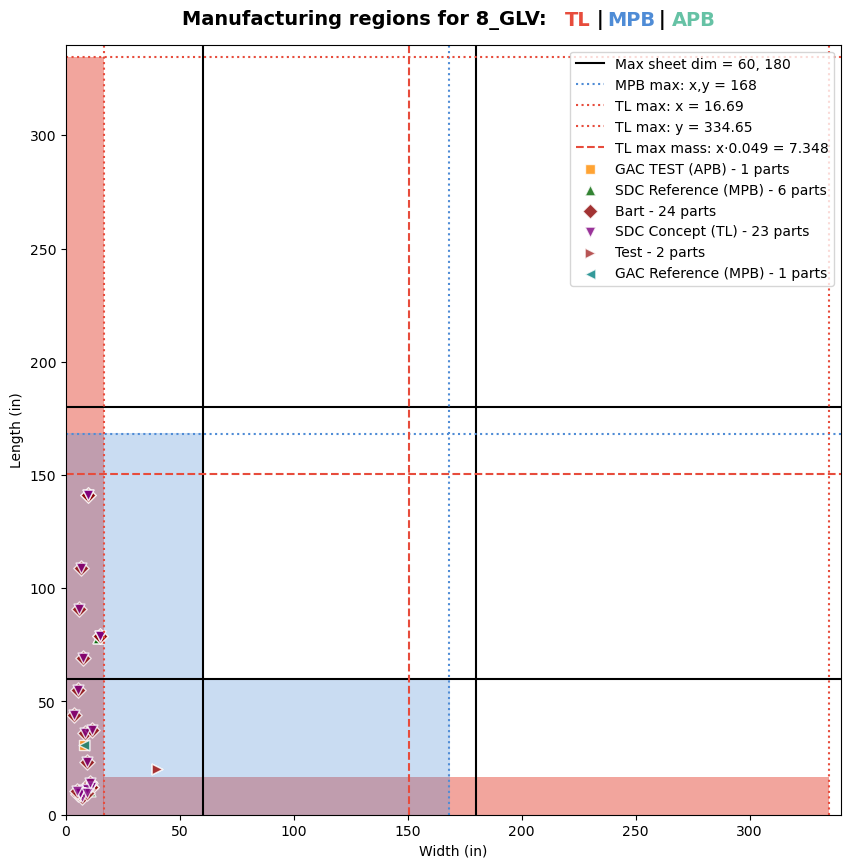

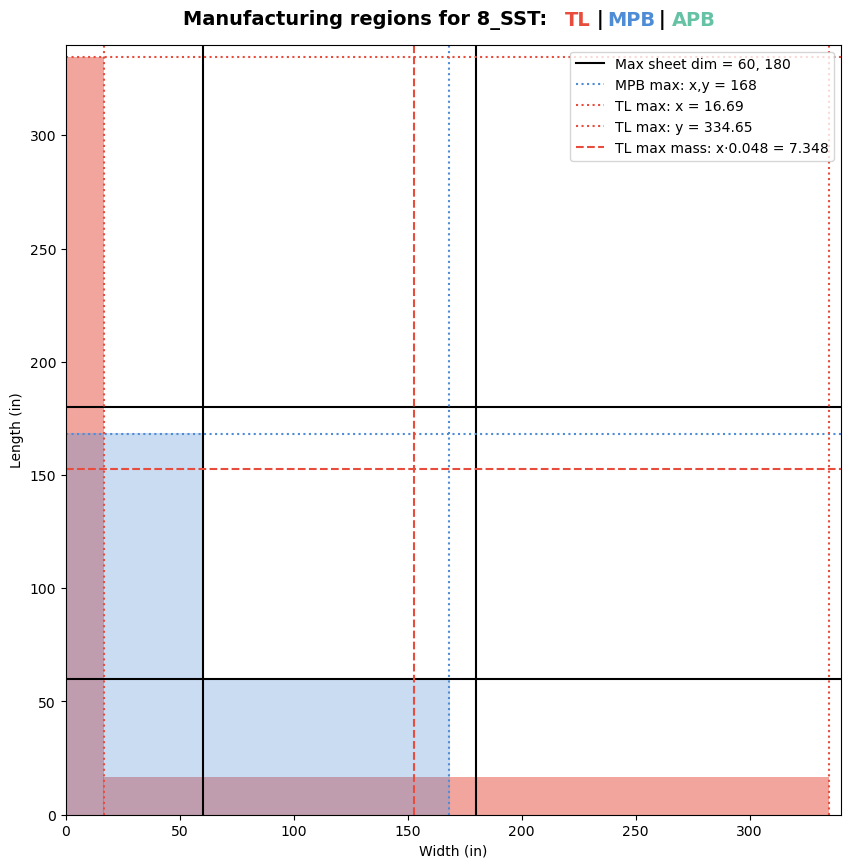

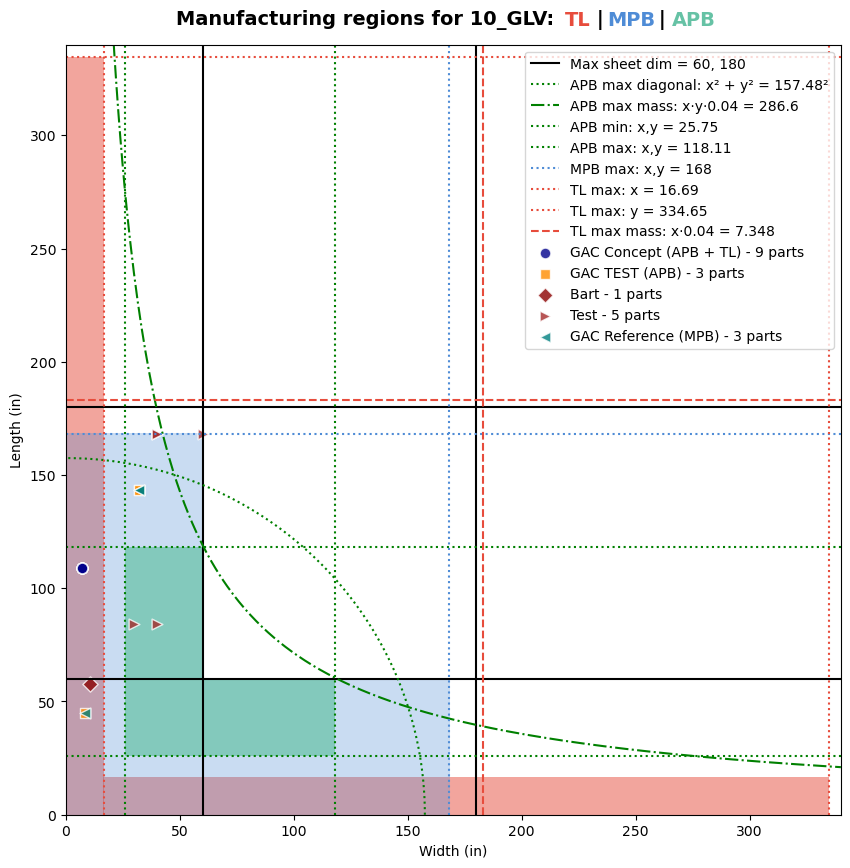

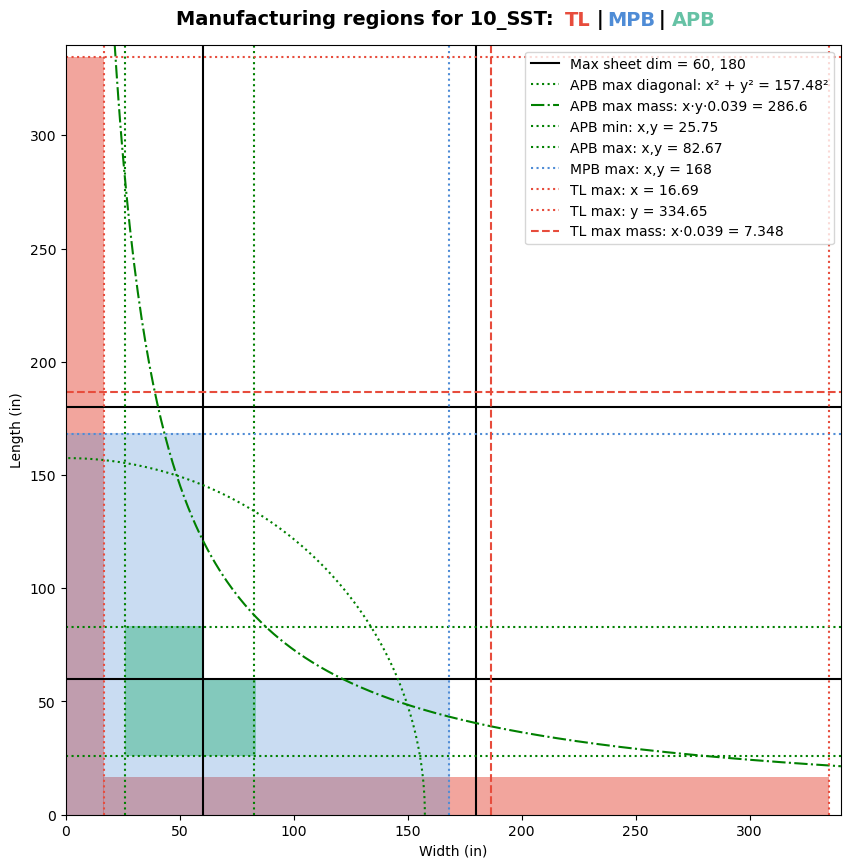

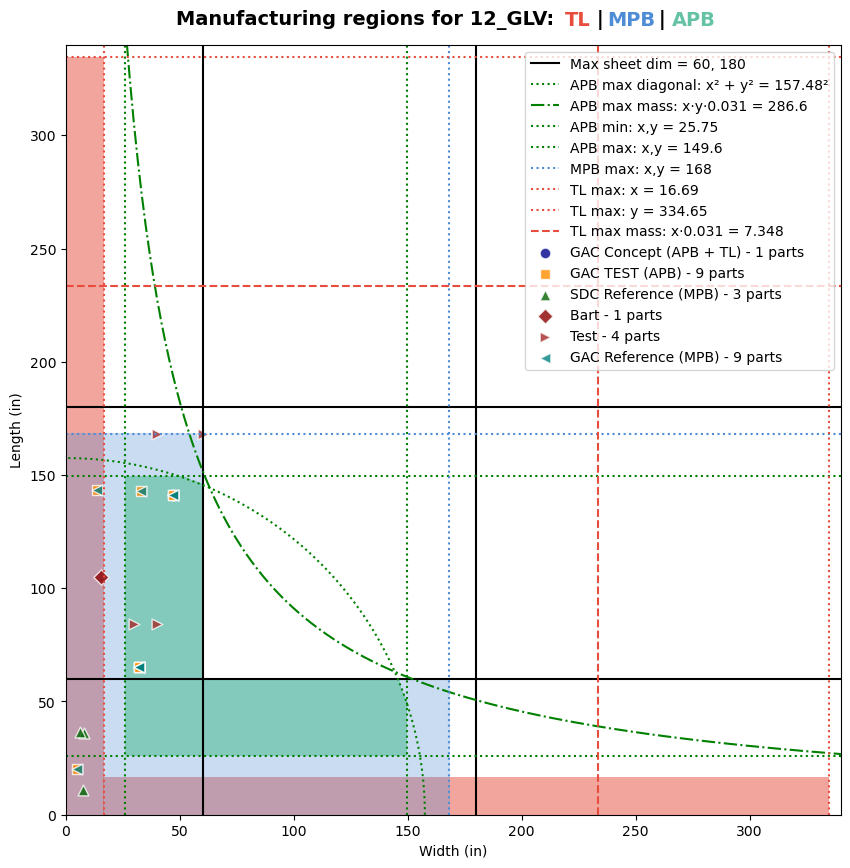

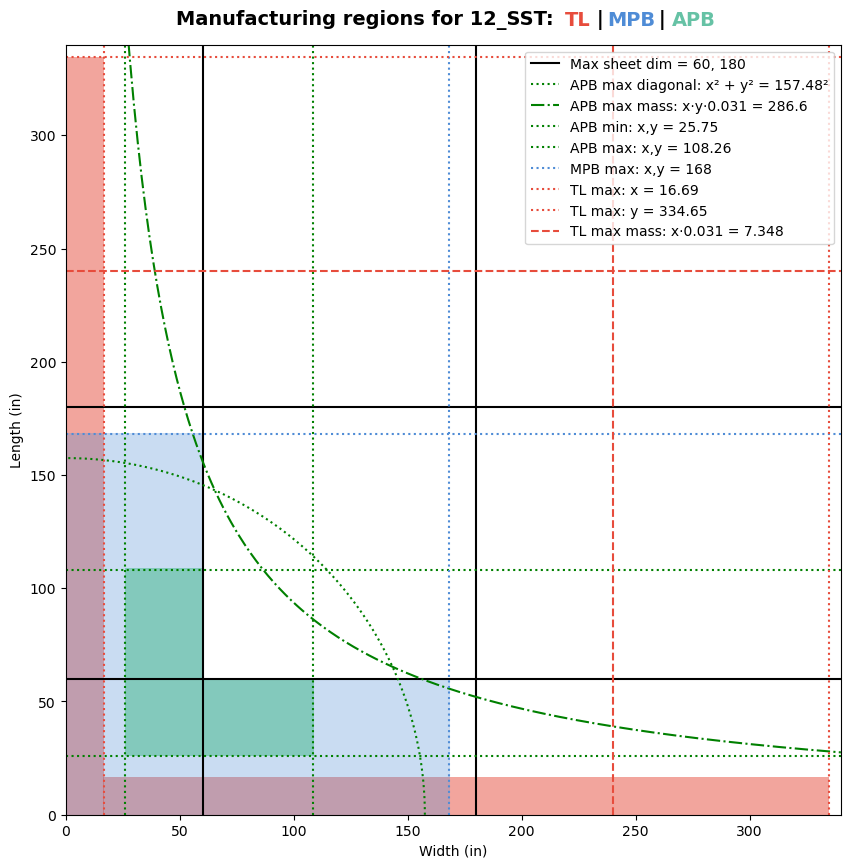

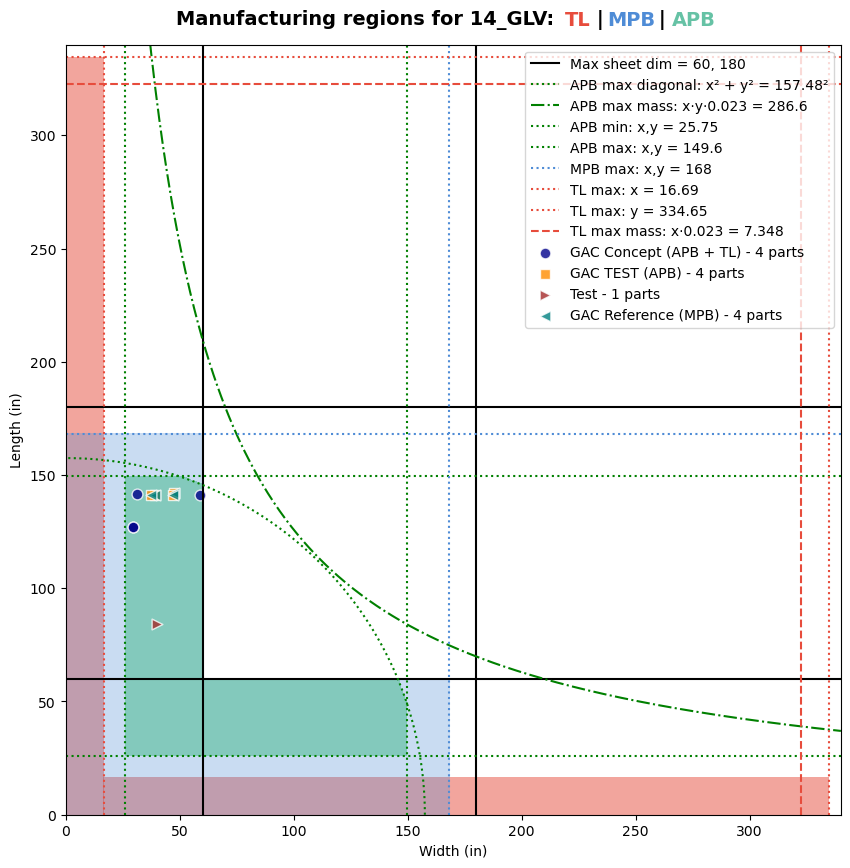

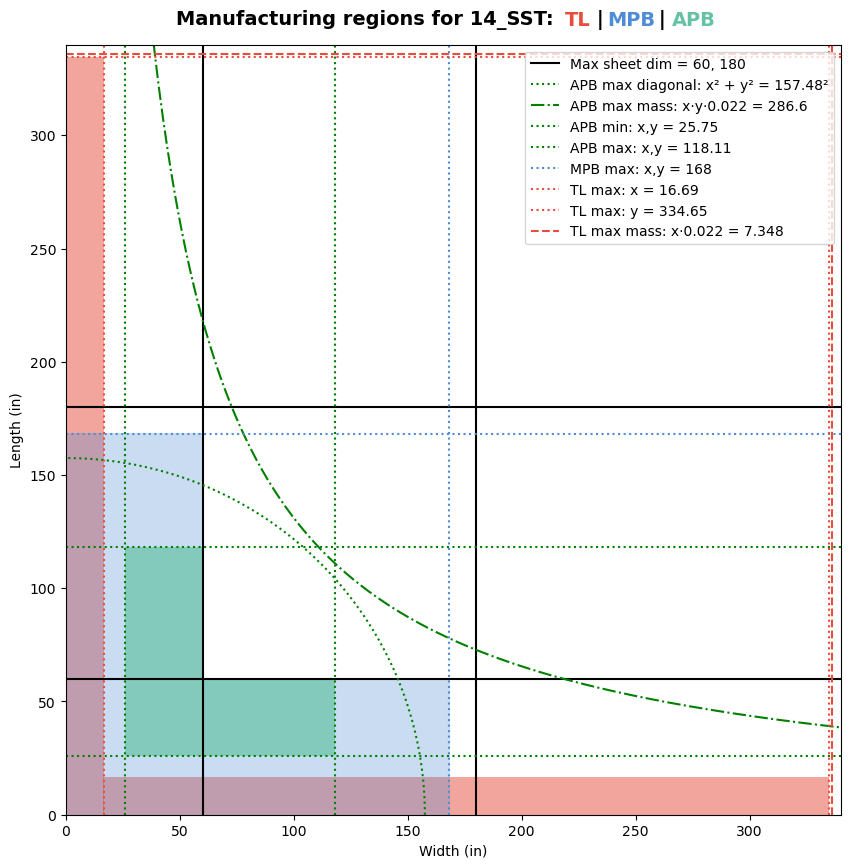

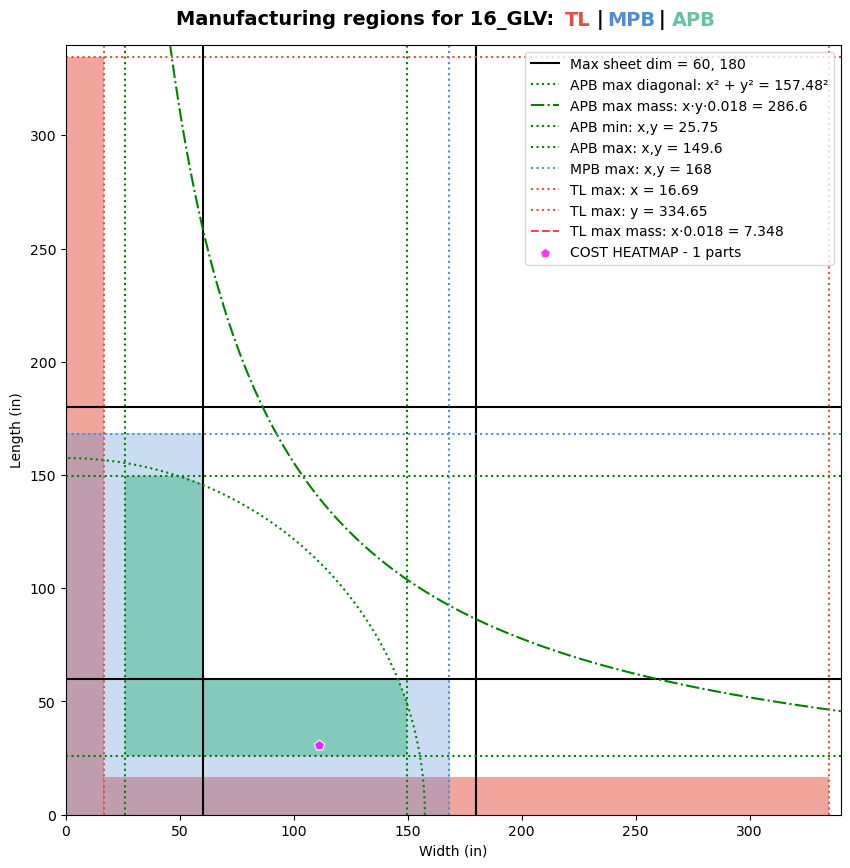

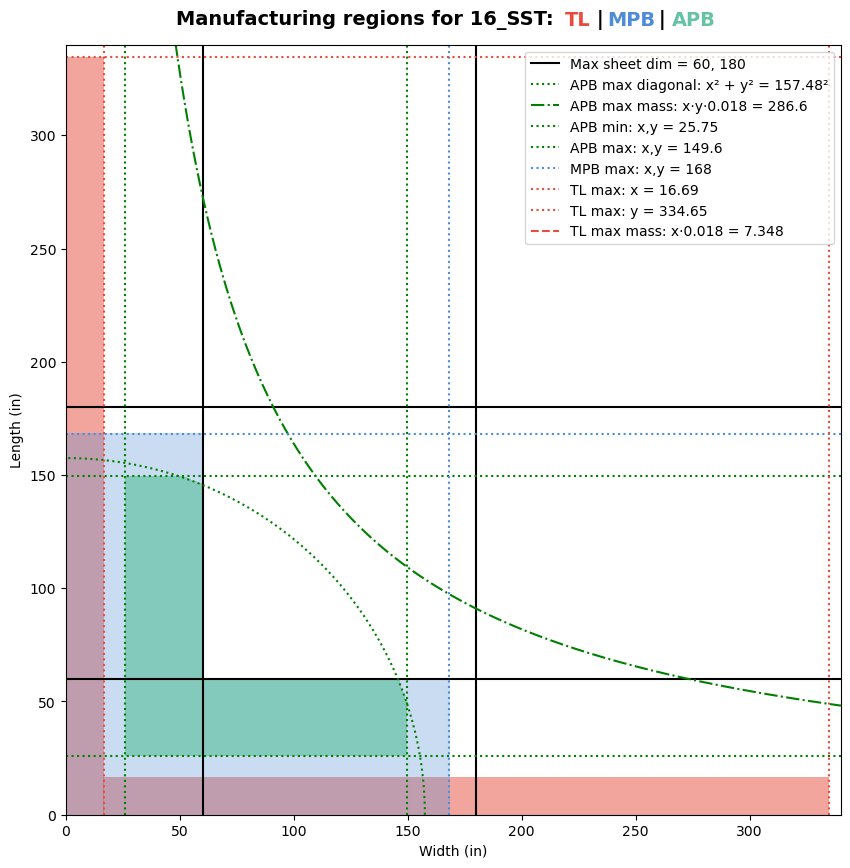

In [338]:
# gauges = df['Gauge'].apply(lambda x: int(x)).unique().tolist()
# materials = df['NCx_Material'].apply(lambda x: str(x)[:3]).unique().tolist() 
gauges = [8, 10, 12, 14, 16]
materials = ['GLV', 'SST']

# Plot all combinations
for gauge in gauges:
    for material in materials:
        cap = Capabilities(material, gauge)
        cap.APB_MPB_TL_plot()
        cap.add_part_sets(part_sets)
        cap.show_plot()